In [1]:
import pandas as pd

In [2]:
# Read the CSV as a single column
df = pd.read_csv("scheduling_results_4_classes_cleaned_50x15_21-02-2025.csv", header=None)

# Split into multiple columns using the semicolon as a delimiter
df = df[0].str.split(';', expand=True)

In [3]:
# Assign proper column names
df.columns = ['instance', 'jobs', 'machines', 'strategy', 'tw', 'compression', 
              'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent', 'opt_class']

# Verify the DataFrame
print(df.head())

  instance jobs machines strategy tw compression overlapping  \
0     TA51   50       15    EST-M  2         Yes          No   
1     TA52   50       15    EST-M  2         Yes          No   
2     TA53   50       15    EST-M  2         Yes          No   
3     TA54   50       15    EST-M  2         Yes          No   
4     TA55   50       15    EST-M  2         Yes          No   

  #op_tw_with_overlap #op_tw #op_only_overlap makespan gap_to_opt_percent  \
0                 375    375                0     3070                 11   
1                 375    375                0     3128                 13   
2                 375    375                0     2956                  9   
3                 375    375                0     3039                  7   
4                 375    375                0     2998                 12   

  opt_class  
0         1  
1         1  
2         1  
3         1  
4         1  


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
# Convert numeric columns to appropriate types
numeric_cols = ['jobs', 'machines', 'tw', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Encode categorical variables (e.g., 'strategy', 'compression', 'overlapping')
label_encoder = LabelEncoder()
categorical_cols = ['strategy', 'compression', 'overlapping', 'opt_class']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Define the features (X) and the target variable (y)
x = df[['jobs', 'machines', 'strategy', 'tw', 'compression', 'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap']]
y = df['opt_class']  # Target variable for classification

In [6]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
# Train the Classification Decision Tree
#decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

# extract the set of cost complexity parameter alphas
ccp_alphas = decision_tree.cost_complexity_pruning_path(x_train,y_train)['ccp_alphas']

# view the complete list of effective alphas
ccp_alphas.tolist()

# setup parameter space
parameters = {'ccp_alpha':ccp_alphas.tolist()}

# create an instance of the grid search object
gsearch = GridSearchCV(DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42), parameters, cv=10)

# step 3: conduct grid search over the parameter space
gsearch.fit(x_train,y_train)

# show best parameter configuration found for classifier
gsearch.best_params_

# extract best classifier
clf = gsearch.best_estimator_

# produce classification report
y_pred = clf.predict(x_test)


# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72       148
           1       0.46      0.66      0.54       122
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00        11

    accuracy                           0.57       336
   macro avg       0.29      0.35      0.32       336
weighted avg       0.47      0.57      0.51       336



D:\AAU Data\Seafile AAU\My Library\Research papers\Work with Patrick Rodler\Project\Project\pandas_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\AAU Data\Seafile AAU\My Library\Research papers\Work with Patrick Rodler\Project\Project\pandas_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\AAU Data\Seafile AAU\My Library\Research papers\Work with Patrick Rodler\Project\Project\pandas_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is il

C:\Users\Mohammed El-Kholany\AppData\Local\Temp\ipykernel_10404\3738993400.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


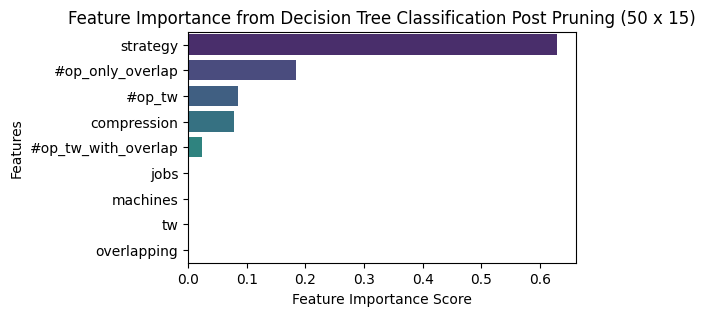

In [11]:
# Feature Importance Analysis
feature_importances = clf.feature_importances_
features = x.columns
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(5, 3))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Decision Tree Classification Post Pruning (50 x 15)")
plt.show()